In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
vote = pd.read_csv("../W11/county_level_election.csv")
vote.head()

,state,fipscode,county,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,votergap,trump,clinton
0,Colorado,8117,Summit County,27239,15.173,4.918,45.996,2.5,68352,5.4,48.1,8.1,13.1,46.0,46.2,-27.632,31.530,59.162
1,Colorado,8037,Eagle County,53653,30.040,5.169,47.231,3.1,76661,10.1,47.3,9.4,11.8,31.0,47.1,-19.897,36.058,55.955
2,Idaho,16067,Minidoka County,19226,34.070,5.611,49.318,3.7,46332,24.1,11.8,18.3,34.2,80.0,61.8,54.148,71.135,16.987
3,Colorado,8113,San Miguel County,7558,10.154,4.747,46.808,3.7,59603,4.7,54.4,12.4,16.7,5.7,62.6,-44.769,23.892,68.662
4,Utah,49051,Wasatch County,21600,13.244,4.125,48.812,3.4,65207,9.5,34.4,13.9,23.0,257.8,68.3,25.357,50.471,25.114


# Exploratory Data Analysis
### 1. Estimate the national overall votergap, assuming the entire population voted?

In [3]:
calculation = vote.copy()
calculation["true_population"] = calculation["votergap"] * calculation["population"] / 100

In [4]:
calculation["true_population"].sum() / calculation["population"].sum() * 100

-2.788506804371381

*To get the true population overall votergap, we take the sum of the voter gap% divided by the sum of population * 100.*
*The national overall votergap will be -2.79%.*

### 2. What is the average votergap, assuming all counties are weighted equally?

In [5]:
temp1 = calculation.groupby(["state", "county"])[["population", "true_population"]].sum()
temp1["county_votergap"] =  temp1["true_population"] / temp1["population"] * 100

In [6]:
temp1["county_votergap"].mean()

31.723198303979125

In [7]:
calculation["votergap"].mean()

31.723198303979125

*The average votergap assuming all counties are weighted equally will be 31.72%.*

### 3. What is the average votergap, assuming all states are weighted equally?

In [8]:
temp2 = calculation.groupby("state")[["population", "true_population"]].sum()
temp2["state_votergap"] =  temp2["true_population"] / temp2["population"] * 100

In [9]:
temp2["state_votergap"].mean()

2.9734235672898266

# Decision Trees

**Building Decision Tree Model**

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [11]:
# "state", "county" excluded from the model
X = vote[["fipscode", "population", "hispanic", "minority", "female", "unemployed", "income", "nodegree", "bachelor", "inactivity", "obesity", "density", "cancer", "trump", "clinton"]]
y = vote["votergap"]

In [12]:
# train - test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### 1. Plot the number of nodes (max depth) on the X axis against the accuracy on the y axis, with separate lines for the training data and the mean cross validation.

**Method 1: Using cross-validation**  
reference: https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6

In [13]:
# define two functions to run cross validation on decision tree
 
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=10, scoring='neg_mean_squared_error'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    
    for depth in tree_depths:
        tree_model = DecisionTreeRegressor(max_depth=depth, random_state = 5)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
        
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    
    return cv_scores_mean, cv_scores_std, accuracy_scores

In [14]:
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation MSE', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train MSE', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    #ax.set_ylabel('(Negative) Mean Squared Error', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()
    ax.axvline(x=cv_scores_mean.argmax()+1, color='orange', linestyle='--') # plt.axvline(x=7, color='orange', linestyle='--')

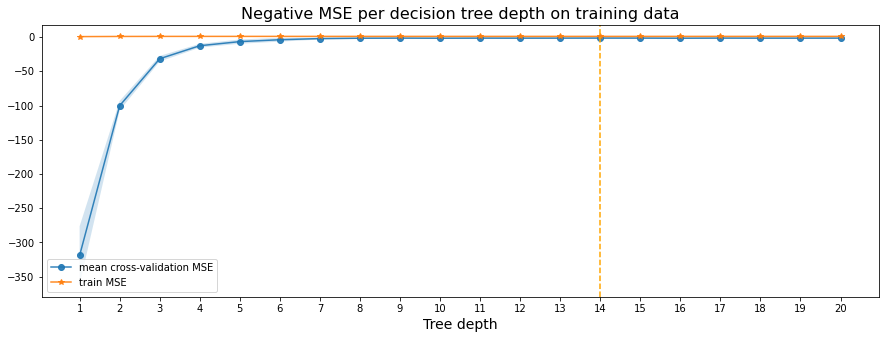

In [15]:
# fitting trees of depth 1 to 20
sm_tree_depths = range(1, 21)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Negative MSE per decision tree depth on training data')

In [16]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-14 tree achieves the best mean cross-validation accuracy -147.77371 +/- 52.59628% on training dataset


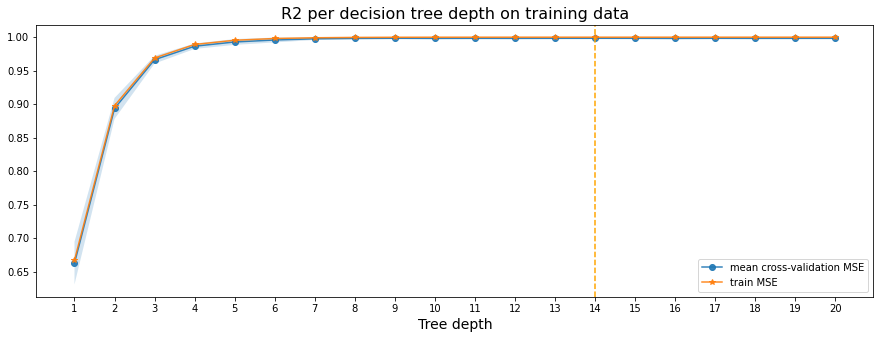

In [17]:
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths, scoring="r2")
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'R2 per decision tree depth on training data')

*Using both (negative) MSE and R-squared metrics, the optimal depth identified is 14.*

**Method2: Using for loop**  
reference: https://towardsdatascience.com/train-a-regression-model-using-a-decision-tree-70012c22bcc1

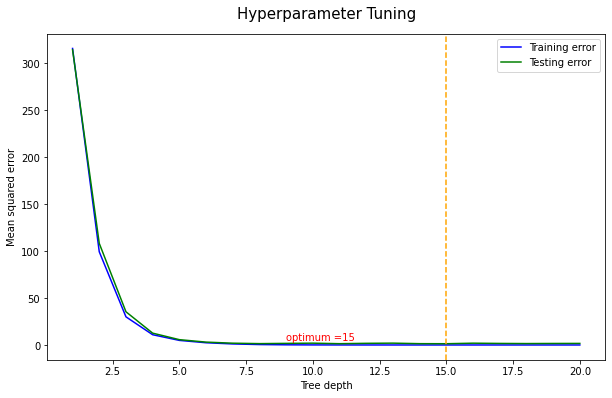

In [18]:
from sklearn.metrics import mean_squared_error as mse

max_depths = range(1, 21)
training_error = []
for max_depth in max_depths:
    model_1 = DecisionTreeRegressor(max_depth=max_depth)
    model_1.fit(X, y)
    training_error.append(mse(y, model_1.predict(X)))
    
testing_error = []
for max_depth in max_depths:
    model_2 = DecisionTreeRegressor(max_depth=max_depth)
    model_2.fit(X_train, y_train)
    testing_error.append(mse(y_test, model_2.predict(X_test)))

plt.figure(figsize = (10,6))
plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Tree depth')

# +1 because it starts from 1 node
plt.axvline(x=testing_error.index(min(testing_error))+1, color='orange', linestyle='--') # plt.axvline(x=7, color='orange', linestyle='--')
plt.annotate('optimum ='+str(testing_error.index(min(testing_error))+1), xy=(9, 5), color='red') # plt.annotate('optimum = ?', xy=(7.5, 1.17), color='red')
plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend()

### 2. Based on the plot, how many nodes would you recommend as the max depth?

*I would recommend depth = 14, since this depth is corresponding to a minimal MSE or a highest R2 on the training data.*

###  3. The cross validation starts to fall off at a certain point, why?

*The model is increasing the number of depth or the complexity. At the same time, the model's bias is decrease and start to fit the data better. The model starts with depth = 1, which is essentially only one root. As expected, this model is too simple and cannot explain the data. The point at which the cross validation fall off dramatically is when the model starts to capture the essence of data pattern and thus there is a huge increase in performance. It also implies that the added predictor is helping a lot in increasing prediction accuracy.*  
*As the depth increases, cross validation is gradually going flat. This means not much increase in the performance of model when further increase the depth. In other words, the model performs the best approximately when it reaches depth = 18, and further depth does not increase accuracy much. This is likely due to the fact that we put around 15 features in the model, and too much further branching might not help prediction.*